# In Face FW for Neural Networks - 1 Layer

This notebook implements our algorithm for a one layer feed forward neural network

## Preliminary (packages, auxiliary functions)

In [2]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt

In [3]:
def sigmoid(u):
    return(1/(1+np.exp(-u)))

In [4]:
def sigmoid_prime(u):
    return(1/(4*(np.cosh(u/2))**2))

In [5]:
def mat2vec(A):
    res = np.array([])
    n,p = np.shape(A)
    for i in range(n):
        res = np.concatenate((res,A[i,:]),axis=0)
    return(res)


            
        

In [6]:
mat2vec(np.identity(3))

array([1., 0., 0., 0., 1., 0., 0., 0., 1.])

In [7]:
def vec2mat(a,n,p):
    res = np.zeros((n,p))
    for i in range(n):
        res[i,:]=a[(i*p):((i+1)*p)]
    return(res)
    


In [8]:
vec2mat(np.array([1., 0., 0., 0., 1., 0., 0., 0., 1.,1,2,3]),4,3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 2., 3.]])

In [9]:
def lipschitz(X,Y,k0,k1,activation):
    '''returns the array of lipschitz constants'''
    
    


## Loss function (MSE)

In [10]:
def loss(W,X,Y,sigma):
    n,p = np.shape(X)
    _,q = np.shape(Y)
    k1,k0 = np.shape(W)
    res = 0
    for i in range(n):
        loss_i = np.linalg.norm(Y[i,:] - sigma(np.matmul(W,X[i,:])))**2
        res+=loss_i
    return((0.5*res)/n)
    

In [11]:
#test

Y = np.array([np.matmul(np.ones((3,2)),[10,11]),np.matmul(np.ones((3,2)),[12,13])])
loss(np.ones((3,2)), np.array([[10,11],[12,13]]),Y,lambda x: x)

0.0

## Gradient 

In [12]:
def gradient(W,x,y,sigma, sigma_prime):
    
#     print(loss(W,np.array([x]),np.array([y]),sigma))
    
    x = np.array(x)
    y=np.array(y)
    
    k1, k0 = np.shape(W)
    #print(W @ x.reshape(-1,1))
    
    input1 = np.matmul(W,x)
#     print("input1",input1)
    
    u1 = sigma(input1) - y 
#     print("u1",u1)
    
    u2 = np.diag(sigma_prime(input1))
#     print("u2",u2)   
    u3 = np.zeros((k1,k1*k0))

    for i in range(k1):
        u3[i,k0*i:k0*(i+1)] = x
#     print("u3",u3)    
    return(u1 @ u2 @ u3)
    


In [13]:
#test
gradient(np.ones((2,3)),[4,-2,8],[-1,30],sigmoid,sigmoid_prime)
# np.matmul(np.identity(2),[1,2])
# tested with an extraneous calculator for the linear case and sigmoid case

array([ 0.00036316, -0.00018158,  0.00072632, -0.00526592,  0.00263296,
       -0.01053184])

## Implement FW Step

In [14]:
def create_extremal_points(k0,k1,delta):
    extremal_points = [np.zeros((k0*k1,)) for i in range(2*k0*k1)]
    for i in range(2*k0*k1):
        extremal_points[i][int(i/2)]=(-1)**i*delta
    return(extremal_points)


In [15]:
def fw_step(W,L,df,delta,Gtilde_1=np.inf,mode="basis"):
    '''
    - mode: basis or linprog
    '''
#     df = gradient()

    w = mat2vec(W)
    
    k1,k0 = np.shape(W) 

    
    if mode == "basis":
        extremal_points = create_extremal_points(k0,k1,delta)
        print("extremal_points: ", extremal_points)
        g = lambda x: np.inner(df,x)
        candidate_objectives = list(map(g,extremal_points))
        winner_index = np.argmin(candidate_objectives)
        w_tilde = extremal_points[winner_index]
        print("w_tilde",w_tilde)
        
    #return(w_tilde)
    
#     w_tilde = np.array([X_tilde])
    print("w_tilde",w_tilde)
    #fw gap
    G = df.T @ (w - w_tilde)
    G_tilde = min(G,Gtilde_1)
    
    #curvature Ck
    C = L * np.linalg.norm(w-w_tilde)**2
    
    print("Ck: ",C)
    
    #time step
    alpha = min(G/C,1)
    wiplus1 = w + alpha*(w_tilde-w)
    
    if G <= C:
        theta = G**2/(2*C)
    else:
        theta = G/2
    
    return(vec2mat(wiplus1,k1,k0),G_tilde,theta)


In [16]:
fw_step(np.zeros((2,1)),1,np.ones((2*1,))*0.5,0.1,mode="basis")
#tested by comparing with AMPL

extremal_points:  [array([0.1, 0. ]), array([-0.1,  0. ]), array([0. , 0.1]), array([ 0. , -0.1])]
w_tilde [-0.1  0. ]
w_tilde [-0.1  0. ]
Ck:  0.010000000000000002


(array([[-0.1],
        [ 0. ]]), 0.05, 0.025)

## Implement In Face Step

In [17]:
def find_inface_dir(W,delta,df, mode = "basis"):
    
    k1,k0 = np.shape(W)
    
    w = mat2vec(W)

    if mode == "basis":
        extremal_points = create_extremal_points(k0,k1,delta)
        I_plus = (w>0)
        I_zero = (w == 0)
        I_minus = (w<0)
        
        IF_extremal_points = []
        
        #take only in face extremal points
        for p in extremal_points:
            b1 = np.prod(p[I_plus]>=0)
            b2 = np.prod(p[I_zero] == 0)
            b3 = np.prod(p[I_minus] <= 0)
            if b1 + b2 + b3 == 3:
                IF_extremal_points.append(p)
        
        g = lambda x: np.inner(df,x)
        candidate_objectives = list(map(g,IF_extremal_points))
        winner_index = np.argmin(candidate_objectives)
        w_hat = IF_extremal_points[winner_index]
        print(w_hat)
    
    return(vec2mat(w_hat,k1,k0) - W)
    
    
    
    

In [18]:
def find_alpha_stop(W,delta,df,d,mode="basis"):
    
    k1,k0 = np.shape(W)
    
    if mode == "linprog":
        A_ub,b_ub,A_eq,b_eq,c = create_matrix_inface(W,delta,df)

        print(A_ub.shape,b_ub.shape,A_eq.shape,b_eq.shape,c.shape)

        #add column for variable alpha

        A_ub = np.concatenate((A_ub, np.zeros((np.shape(A_ub)[0],1))),axis=1)
        #b_ub = np.concatenate((b_ub, np.array([0])),axis=0)
        A_eq = np.concatenate((A_eq, np.zeros((np.shape(A_eq)[0],1))),axis=1)
        #b_eq = np.concatenate((b_eq, np.array([0])),axis=0)
        c = np.zeros(np.shape(c))
        c = np.concatenate((c,np.array([-1])),axis=0) # max alpha = min -alpha

        #constraints w - alpha*d = W
        A_line = np.zeros((k0*k1,3*k0*k1))
        for i in range(k0*k1):
            A_line[i,(i*3):((i+1)*3)]=np.array([0,0,1])
        A_line = np.concatenate((A_line, -np.ones((np.shape(A_line)[0],1))),axis=1)

        A_eq = np.concatenate((A_eq,A_line),axis=0)

        b_eq = np.concatenate((b_eq,mat2vec(W)),axis=0)

        print(A_ub.shape,b_ub.shape,A_eq.shape,b_eq.shape,c.shape)

        res = linprog(c=c,A_ub=A_ub,b_ub=b_ub,A_eq=A_eq,b_eq=b_eq,bounds=[-np.inf,np.inf])["x"]
#         print(res)
    
    if mode == "basis":
        res=[1]
    
    return(res[-1])#last variable is alpha
    
    

In [19]:
find_alpha_stop(np.array([[0.5],[0.5],[0]]),1,np.array([0,1,0]),find_inface_dir(np.array([[0.5],[0.5],[0]]),1,np.array([0,1,0])))
#np.ones((2,1))+alpha_stop*(-2*np.ones((2*1,)))

[1. 0. 0.]


1

## Main Function

In [20]:
def fw_noncvx(X,Y,delta,W,T,gamma_1,gamma_2, activation="linear",sigma=None,sigma_prime=None,k0=None,k1=None,L=None):
    '''
    Input:
    X: n x p array 
    Y: n x q array (q dimension of output layer)
    
    
    '''
    
    if(activation == "linear") and sigma is None:
        sigma = lambda x: x
        sigma_prime = lambda x: np.ones(np.shape(x))
        
#     W = np.zeros((k1,k0))
#     i,j = np.random.randint(0,k1-1,1), np.random.randint(0,k0-1,1)
#     W[i,j]=delta
#     L = lipschitz(k0,k1)

    k1,k0 = np.shape(W)

    print("Begin Iteration ",0)
#     L=10
    n,p = np.shape(X)
    _,q = np.shape(Y)
    
    print(n,p,q)
    
    df = np.zeros((k0*k1,))
    for i in range(n):
        df+=gradient(W,X[i,:],Y[i,:],sigma, sigma_prime)
    df/=n
    
    print("Gradient: ", df)
    print("Initial Loss", loss(W,X,Y,sigma))
    
    W, G_tilde, theta = fw_step(W,L,df,delta)
    
    print(W,G_tilde,theta)
    
    #loss function
    f = lambda W: loss(W,X,Y,sigma)
    
    objectives=[f(W)]
    
    for k in range(1,T):
        print("Begin Iteration ",k)
        
        #Compute gradient
        df = np.zeros((k0*k1,))
        for i in range(n):
            df+=gradient(W,X[i,:],Y[i,:],sigma, sigma_prime)
        df/=n
        print("Gradient: ", df)
        #Inface direction
        d = find_inface_dir(W,delta,df)
        
        
        #alpha_stop = find_alpha_stop(W,delta,df,d)
        
        alpha_stop = 1
        
        #(a) Go to lower dimensional face
        W_B = W + alpha_stop*d
        beta = np.random.uniform()*alpha_stop
        W_A = W + beta*d
        
        if(f(W_B) <= f(W) - gamma_1*theta):
            print("--(a)--")
            W = W_B
            G_tilde = G_tilde
            theta = theta
        
        #(b) Stay in current face
        elif(f(W_A) <= f(W) - gamma_2*theta):
            print("--(b)--")
            W = W_A
            G_tilde = G_tilde
            theta = theta
        
        #(c) Regular FW step
        else:
            print("FW")
            W, G_tilde, theta = fw_step(W,L,df,delta,Gtilde_1=G_tilde)
        print("W: ", W)
        if G_tilde==0:
            break
        objectives.append(f(W))
    return(W,objectives)

## Numerical Tests

Create random training features data

In [21]:
np.random.seed(8)
X = np.random.rand(10,5)
X

array([[0.8734294 , 0.96854066, 0.86919454, 0.53085569, 0.23272833],
       [0.0113988 , 0.43046882, 0.40235136, 0.52267467, 0.4783918 ],
       [0.55535647, 0.54338602, 0.76089558, 0.71237457, 0.6196821 ],
       [0.42609177, 0.28907503, 0.97385524, 0.33377405, 0.21880106],
       [0.06580839, 0.98287055, 0.12785571, 0.32213079, 0.07094284],
       [0.22476994, 0.39363491, 0.896145  , 0.34546161, 0.98474944],
       [0.02873205, 0.35168474, 0.38095889, 0.76416013, 0.93880391],
       [0.3196898 , 0.43247593, 0.27014574, 0.80105589, 0.63823881],
       [0.06869013, 0.60364448, 0.79557456, 0.03200816, 0.45544782],
       [0.79017254, 0.98859652, 0.58396454, 0.0389123 , 0.44642291]])

Set the labels to be linear in the features, using a sparse coefficient. Initialize at another weight vector.

In [22]:
W_star = np.array([[0,0,0,1,0]])
Y = X @ W_star.T
Y
delta = 1
W0 = np.array([[0, -1,0,0,0]])
T=200
gamma_1 = 0.1
gamma_2 = 0.1

In [23]:
_,l1 = fw_noncvx(X,Y,delta,W0,T,gamma_1,gamma_2,L=0.5)

Begin Iteration  0
10 5 1
Gradient:  [-0.38172543 -0.66239176 -0.59420849 -0.49734613 -0.51228433]
Initial Loss 0.5798689448794246
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0.,  0.,  0., -1.])]
w_tilde [0. 1. 0. 0. 0.]
w_tilde [0. 1. 0. 0. 0.]
Ck:  2.0
[[0.         0.32478352 0.         0.         0.        ]] 1.3247835199470195 0.43876284368080376
Begin Iteration  1
Gradient:  [-0.0637838  -0.09596501 -0.13095749 -0.18624719 -0.16636717]
[0. 1. 0. 0. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0

In [24]:
_,l2 = fw_noncvx(X,Y,delta,W0,T,gamma_1 = np.inf,gamma_2=np.inf,L=0.5)

Begin Iteration  0
10 5 1
Gradient:  [-0.38172543 -0.66239176 -0.59420849 -0.49734613 -0.51228433]
Initial Loss 0.5798689448794246
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0.,  0.,  0., -1.])]
w_tilde [0. 1. 0. 0. 0.]
w_tilde [0. 1. 0. 0. 0.]
Ck:  2.0
[[0.         0.32478352 0.         0.         0.        ]] 1.3247835199470195 0.43876284368080376
Begin Iteration  1
Gradient:  [-0.0637838  -0.09596501 -0.13095749 -0.18624719 -0.16636717]
[0. 1. 0. 0. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0

extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0.,  0.,  0., -1.])]
w_tilde [0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 1. 0.]
Ck:  3.9287009827872025e-06
W:  [[0.00000000e+00 6.22944811e-04 0.00000000e+00 9.98081969e-01
  0.00000000e+00]]
Begin Iteration  20
Gradient:  [-0.00012234 -0.00018406 -0.00025118 -0.00035723 -0.0003191 ]
[0. 0. 0. 1. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0.,  0.,  0., -1.])]
w_tilde [0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 1. 0.]
Ck:  2

FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0.,  0.,  0., -1.])]
w_tilde [0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 1. 0.]
Ck:  7.480746730552544e-12
W:  [[0.00000000e+00 8.59602284e-07 0.00000000e+00 9.99997353e-01
  0.00000000e+00]]
Begin Iteration  40
Gradient:  [-1.68816131e-07 -2.53989923e-07 -3.46604291e-07 -4.92939151e-07
 -4.40322844e-07]
[0. 0. 0. 1. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0.,  0.,  0., -1.])]
w_tilde [0. 0. 0. 1. 0.]
w_tilde 

Gradient:  [-8.69545540e-10 -1.30826245e-09 -1.78530460e-09 -2.53905262e-09
 -2.26803424e-09]
[0. 0. 0. 1. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0.,  0.,  0., -1.])]
w_tilde [0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 1. 0.]
Ck:  1.0272745474841231e-16
W:  [[0.00000000e+00 3.18543209e-09 0.00000000e+00 9.99999990e-01
  0.00000000e+00]]
Begin Iteration  57
Gradient:  [-6.25582702e-10 -9.41211606e-10 -1.28441309e-09 -1.82668684e-09
 -1.63170636e-09]
[0. 0. 0. 1. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  

w_tilde [0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 1. 0.]
Ck:  1.9560504732465622e-22
W:  [[0.00000000e+00 4.39556626e-12 0.00000000e+00 1.00000000e+00
  0.00000000e+00]]
Begin Iteration  77
Gradient:  [-8.63237332e-13 -1.29877623e-12 -1.77235592e-12 -2.52064012e-12
 -2.25158981e-12]
[0. 0. 0. 1. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0.,  0.,  0., -1.])]
w_tilde [0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 1. 0.]
Ck:  1.0124292361965057e-22
W:  [[0.00000000e+00 3.16233011e-12 0.00000000e+00 1.00000000e+00
  0.00000000e+00]]
Begin Iteration  78
Gradient:  [-6.21047673e-13 -9.34390017e-13 -1.27511022e-12 -1.81344646e-12
 -1.61988559e-12]
[0. 0. 0. 1. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0

Begin Iteration  102
Gradient:  [-2.23378387e-16 -3.31899504e-16 -4.56030581e-16 -6.50544240e-16
 -5.78073147e-16]
[0. 0. 0. 1. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0.,  0.,  0., -1.])]
w_tilde [0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 1. 0.]
Ck:  6.99862440884774e-30
W:  [[0.00000000e+00 8.50733264e-16 0.00000000e+00 1.00000000e+00
  0.00000000e+00]]
Begin Iteration  103
Gradient:  [-1.58509238e-16 -2.39893556e-16 -3.29883519e-16 -4.72554144e-16
 -4.21194560e-16]
[0. 0. 0. 1. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.])

Begin Iteration  119
Gradient:  [5.48292343e-19 6.85976635e-19 4.05206801e-19 2.70008305e-20
 3.09768119e-19]
[0. 0. 0. 1. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0.,  0.,  0., -1.])]
w_tilde [ 0. -1.  0.  0.  0.]
w_tilde [ 0. -1.  0.  0.  0.]
Ck:  1.0000000000000002
W:  [[0.00000000e+00 3.23467331e-18 0.00000000e+00 1.00000000e+00
  0.00000000e+00]]
Begin Iteration  120
Gradient:  [0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.])

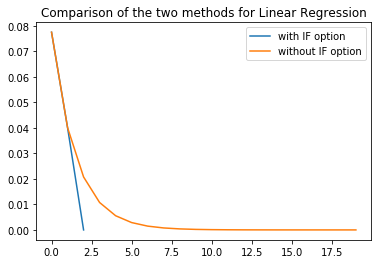

In [25]:
plt.plot(list(range(len(l1))),l1, label = "with IF option")
plt.plot(list(range(20)),l2[:20], label = "without IF option")
plt.legend()
plt.title("Comparison of the two methods for Linear Regression")
plt.savefig("1layer_exp1.png")

Then repeat but this time we add the sigmoid activation function (logistic regression since only one layer)

In [26]:
W_star = np.array([[0,0,0,1,0]])
Y = sigmoid(X @ W_star.T)
print(Y)
delta = 1
W0 = np.array([[0, -1,0,0,0]])
T=200
gamma_1 = 0.1
gamma_2 = 0.1

[[0.62968267]
 [0.62777298]
 [0.67092564]
 [0.58267738]
 [0.57984345]
 [0.5855166 ]
 [0.68225626]
 [0.6902003 ]
 [0.50800136]
 [0.50972685]]


In [27]:
_,l3 = fw_noncvx(X,Y,delta,W0,T,gamma_1,gamma_2,L=0.5,sigma = sigmoid, sigma_prime = sigmoid_prime)

Begin Iteration  0
10 5 1
Gradient:  [-0.01957624 -0.03404684 -0.03212101 -0.02739635 -0.02863468]
Initial Loss 0.033276620874433324
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0.,  0.,  0., -1.])]
w_tilde [0. 1. 0. 0. 0.]
w_tilde [0. 1. 0. 0. 0.]
Ck:  2.0
[[ 0.         -0.93190632  0.          0.          0.        ]] 0.06809368364288283 0.0011591874380142521
Begin Iteration  1
Gradient:  [-0.0191981  -0.03334289 -0.0313717  -0.02688145 -0.02797986]
[ 0. -1.  0.  0.  0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0

[ 0. -1.  0.  0.  0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0.,  0.,  0., -1.])]
w_tilde [0. 1. 0. 0. 0.]
w_tilde [0. 1. 0. 0. 0.]
Ck:  0.6945585569172132
W:  [[ 0.         -0.14072794  0.          0.          0.        ]]
Begin Iteration  16
Gradient:  [-0.01067097 -0.017967   -0.0178989  -0.01784832 -0.01741474]
[ 0. -1.  0.  0.  0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0.,  0.,  0., -1.])]
w_tilde [0. 1. 0. 0. 0.]
w_tilde [0. 1. 0. 0. 0

In [28]:
_,l4 = fw_noncvx(X,Y,delta,W0,T,gamma_1 = np.inf,gamma_2=np.inf,L=0.5,sigma = sigmoid, sigma_prime = sigmoid_prime)

Begin Iteration  0
10 5 1
Gradient:  [-0.01957624 -0.03404684 -0.03212101 -0.02739635 -0.02863468]
Initial Loss 0.033276620874433324
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0.,  0.,  0., -1.])]
w_tilde [0. 1. 0. 0. 0.]
w_tilde [0. 1. 0. 0. 0.]
Ck:  2.0
[[ 0.         -0.93190632  0.          0.          0.        ]] 0.06809368364288283 0.0011591874380142521
Begin Iteration  1
Gradient:  [-0.0191981  -0.03334289 -0.0313717  -0.02688145 -0.02797986]
[ 0. -1.  0.  0.  0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0

Gradient:  [-0.00975992 -0.01638273 -0.01647652 -0.01666603 -0.01618905]
[0. 0. 0. 1. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0.,  0.,  0., -1.])]
w_tilde [0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 1. 0.]
Ck:  0.46797392874627025
W:  [[ 0.         -0.09701915  0.          0.07419111  0.        ]]
Begin Iteration  19
Gradient:  [-0.00938429 -0.01575296 -0.0158417  -0.01601621 -0.01555758]
[0. 0. 0. 1. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0., 

Gradient:  [-0.00450714 -0.00761514 -0.00761221 -0.00768431 -0.0074406 ]
[0. 0. 0. 1. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0.,  0.,  0., -1.])]
w_tilde [0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 1. 0.]
Ck:  0.11461364381616335
W:  [[ 0.         -0.04738083  0.00754822  0.54031847  0.        ]]
Begin Iteration  39
Gradient:  [-0.00433981 -0.00733381 -0.00733096 -0.00739409 -0.00716053]
[0. 0. 0. 1. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0., 

Gradient:  [-0.00276921 -0.00468573 -0.00469556 -0.00470982 -0.00456305]
[0. 0. 0. 1. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0.,  0.,  0., -1.])]
w_tilde [0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 1. 0.]
Ck:  0.046969023248796656
W:  [[ 0.         -0.02816385  0.00481066  0.70500113  0.        ]]
Begin Iteration  53
Gradient:  [-0.00267253 -0.00452278 -0.00453231 -0.00454313 -0.00440204]
[0. 0. 0. 1. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0.,

extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0.,  0.,  0., -1.])]
w_tilde [0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 1. 0.]
Ck:  0.020144156639321866
W:  [[ 0.         -0.01836552  0.00419871  0.80657088  0.        ]]
Begin Iteration  67
Gradient:  [-0.00169883 -0.00288302 -0.00288398 -0.00288445 -0.00279309]
[0. 0. 0. 1. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0.,  0.,  0., -1.])]
w_tilde [0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 1. 0.]
Ck:  0.018884873095007845

Gradient:  [-0.00103242 -0.00175596 -0.00175498 -0.00175742 -0.00169914]
[0. 0. 0. 1. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0.,  0.,  0., -1.])]
w_tilde [0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 1. 0.]
Ck:  0.007429074930295737
W:  [[ 0.         -0.01074493  0.00321369  0.88236224  0.        ]]
Begin Iteration  86
Gradient:  [-0.001      -0.00170093 -0.0017     -0.00170188 -0.00164552]
[0. 0. 0. 1. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0.,

Ck:  0.003160886113927639
W:  [[ 0.         -0.00685188  0.0022052   0.92320996  0.        ]]
Begin Iteration  102
Gradient:  [-0.00064257 -0.00109389 -0.00109355 -0.00109378 -0.00105725]
[0. 0. 0. 1. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0.,  0.,  0., -1.])]
w_tilde [0. 1. 0. 0. 0.]
w_tilde [0. 1. 0. 0. 0.]
Ck:  0.933036103816865
W:  [[ 0.         -0.00675564  0.00220499  0.92312171  0.        ]]
Begin Iteration  103
Gradient:  [-0.00064192 -0.00109263 -0.00109279 -0.00109377 -0.00105701]
[0. 0. 0. 1. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0

Gradient:  [-0.00043024 -0.00073275 -0.00073288 -0.00073309 -0.00070833]
[0. 0. 0. 1. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0.,  0.,  0., -1.])]
w_tilde [0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 1. 0.]
Ck:  0.0013645514824065623
W:  [[ 0.         -0.00438416  0.00149715  0.9495148   0.        ]]
Begin Iteration  119
Gradient:  [-0.00041737 -0.00071085 -0.00071097 -0.00071109 -0.00068708]
[0. 0. 0. 1. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0

Begin Iteration  137
Gradient:  [-0.00026518 -0.00045189 -0.00045189 -0.00045197 -0.00043657]
[0. 0. 0. 1. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0.,  0.,  0., -1.])]
w_tilde [0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 1. 0.]
Ck:  0.0005270753742813054
W:  [[ 0.         -0.00270128  0.00096934  0.9686131   0.        ]]
Begin Iteration  138
Gradient:  [-0.00025736 -0.00043857 -0.00043857 -0.00043862 -0.00042368]
[0. 0. 0. 1. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0.,

[0. 0. 0. 1. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0.,  0.,  0., -1.])]
w_tilde [0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 1. 0.]
Ck:  0.00023057814015407178
W:  [[ 0.00000000e+00 -1.77561666e-03  6.55642993e-04  9.79236178e-01
   0.00000000e+00]]
Begin Iteration  155
Gradient:  [-0.00016944 -0.00028883 -0.00028881 -0.00028885 -0.00027896]
[0. 0. 0. 1. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0.,  0.,  0., -1.])]
w_tilde [0. 0. 0. 1. 0.]
w_til

Gradient:  [-0.0001055  -0.00017986 -0.00017987 -0.00017987 -0.00017369]
[0. 0. 0. 1. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0.,  0.,  0., -1.])]
w_tilde [0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 1. 0.]
Ck:  8.482389533453707e-05
W:  [[ 0.00000000e+00 -1.06991418e-03  4.00599020e-04  9.87404115e-01
   0.00000000e+00]]
Begin Iteration  175
Gradient:  [-0.00010243 -0.00017463 -0.00017464 -0.00017464 -0.00016864]
[0. 0. 1. 0. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0.

Gradient:  [-7.62751541e-05 -1.30056799e-04 -1.30057570e-04 -1.30070144e-04
 -1.25592562e-04]
[0. 0. 0. 1. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0.,  0.,  0., -1.,  0.]), array([0., 0., 0., 0., 1.]), array([ 0.,  0.,  0.,  0., -1.])]
w_tilde [0. 0. 0. 1. 0.]
w_tilde [0. 0. 0. 1. 0.]
Ck:  4.4501361321239956e-05
W:  [[ 0.00000000e+00 -7.73167170e-04  2.93041319e-04  9.90875973e-01
   0.00000000e+00]]
Begin Iteration  189
Gradient:  [-7.40650282e-05 -1.26288951e-04 -1.26289791e-04 -1.26299136e-04
 -1.21951830e-04]
[0. 0. 0. 1. 0.]
FW
extremal_points:  [array([1., 0., 0., 0., 0.]), array([-1.,  0.,  0.,  0.,  0.]), array([0., 1., 0., 0., 0.]), array([ 0., -1.,  0.,  0.,  0.]), array([0., 0., 1., 0., 0.]), array([ 0.,  0., -1.,  0.,  0.]), array([0., 0., 0., 1., 0.]), array([ 0., 

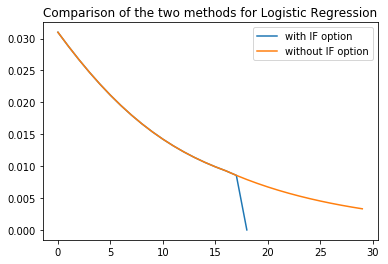

In [29]:
plt.plot(list(range(len(l3))),l3,label = "with IF option")
plt.plot(list(range(30)),l4[:30], label = "without IF option")
plt.legend()
plt.title("Comparison of the two methods for Logistic Regression")
plt.savefig("1layer_exp2.png")